In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.topology import all_rearangements
from tyssue.core.history import HistoryHdf5
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis
from tyssue.behaviors.sheet.basic_events import reconnect

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')



In [2]:
from polarity.dynamics import model
from polarity.apoptosis import apoptosis
from polarity.dynamics import EllipsoidLameGeometry as geom
from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                             )


In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')

today = datetime.date.today().strftime('%Y%m%d')
sim_save_dir = SIM_DIR/f'{today}-QSSolver-Prepolarized_Clone_4cells_no_neighbors'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)

In [5]:
from tyssue.dynamics import units, effectors, model_factory
from polarity.dynamics import RadialTension
model = model_factory(
    [
        RadialTension,
        effectors.LineTension,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [6]:
"""
Mesoderm invagination event module
=======================


"""

import random
import numpy as np

from tyssue.utils.decorators import face_lookup
from tyssue.behaviors.sheet.actions import relax, increase, set_value, increase_linear_tension, decrease
from tyssue.behaviors.sheet.basic_events import contraction_line_tension


default_constriction_spec = {
    "face_id": -1,
    "face": -1,
    "contract_rate": 2,
    "critical_area": 1e-2,
    "radial_tension": 1.0,
    "contract_neighbors": False,
    "critical_area_neighbors": 10,
    "contract_span": 2,
    "basal_contract_rate": 1.001,
    "current_traction": 0,
    "max_traction": 30,
    "contraction_column": "contractility",
}


@face_lookup
def delamination(sheet, manager, **kwargs):
    """Constriction process
    This function corresponds to the process called "apical constriction"
    in the manuscript
    The cell undergoing delamination first contracts its apical
    area until it reaches a critical area. A probability
    dependent to the apical area allow an apico-basal
    traction of the cell. The cell can pull during max_traction
    time step, not necessarily consecutively.
    Parameters
    ----------
    sheet : a :class:`tyssue.sheet` object
    manager : a :class:`tyssue.events.EventManager` object
    face_id : int
       the Id of the face undergoing delamination.
    contract_rate : float, default 2
       rate of increase of the face contractility.
    critical_area : float, default 1e-2
       face's area under which the cell starts loosing sides.
    radial_tension : float, default 1.
       tension applied on the face vertices along the
       apical-basal axis.
    contract_neighbors : bool, default `False`
       if True, the face contraction triggers contraction of the neighbor
       faces.
    contract_span : int, default 2
       rank of neighbors contracting if contract_neighbor is True. Contraction
       rate for the neighbors is equal to `contract_rate` devided by
       the rank.
    """
    constriction_spec = default_constriction_spec
    constriction_spec.update(**kwargs)

    # initialiser une variable face
    # aller chercher la valeur dans le dictionnaire à chaque fois ?
    face = constriction_spec["face"]
    contract_rate = constriction_spec["contract_rate"]
    current_traction = constriction_spec["current_traction"]

    
    
    face_area = sheet.face_df.loc[face, "area"]

    if face_area > constriction_spec["critical_area"]:
        increase_linear_tension(
            sheet,
            face,
            contract_rate,
            multiple=True,
            isotropic=True,
            limit=100)
        # reduce prefered_area
        decrease(sheet,
                 'face',
                 face,
                 constriction_spec["shrink_rate"],
                 col="prefered_area",
                 divide=True,
                 bound=constriction_spec["critical_area"] / 2,
                 )



        if (constriction_spec["contract_neighbors"]) :
            neighbors = sheet.get_neighborhood(
                face, constriction_spec["contract_span"]
            ).dropna()
            neighbors["id"] = sheet.face_df.loc[neighbors.face, "id"].values

            manager.extend(
                [
                    (
                        contraction_line_tension,
                        _neighbor_contractile_increase_delamination(neighbor, constriction_spec),
                    )  # TODO: check this
                    for _, neighbor in neighbors.iterrows()
                ]
            )

    
    if ((current_traction < constriction_spec["max_traction"]) and
            (face_area < constriction_spec["critical_area"])):
        # AB pull
        set_value(sheet,
                  'face',
                  face,
                  constriction_spec['radial_tension'],
                  col="radial_tension")
        current_traction = current_traction + 1
        constriction_spec.update({"current_traction": current_traction})

    manager.append(delamination, **constriction_spec)


def _neighbor_contractile_increase_delamination(neighbor, constriction_spec):

    contract = constriction_spec["contract_rate"]
    basal_contract = constriction_spec["basal_contract_rate"]

    increase = (
        -(contract - basal_contract) / constriction_spec["contract_span"]
    ) * neighbor["order"] + contract

    specs = {
        "face_id": neighbor["id"],
        "contractile_increase": increase,
        "critical_area": constriction_spec["critical_area"],
        "max_contractility": 50,
        "contraction_column": constriction_spec["contraction_column"],
        "multiple": True,
        "unique": False,
    }

    return specs


In [7]:
# Create tissue tissue 

def load_before_apopto(anchor_tension=0):

    #h5store = '../examples/superegg_final.hf5'
    h5store = '../examples/tissue_prepolarized.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    
    with open('../examples/superegg_final.json', 'r+') as fp:
        specs = json.load(fp)
    
    sheet = Sheet('spherical', datasets, specs)
    sheet.settings['geometry'] = "spherical"
    sheet.settings['lumen_vol_elasticity'] = 1.e-6
    #sheet.settings['lumen_prefered_vol'] = sheet.settings['lumen_prefered_vol'] - sheet.settings['lumen_prefered_vol']*10/100

    return sheet

sheet = load_before_apopto(0)

geom.update_all(sheet)



In [8]:
sheet.edge_df.line_tension *= 40.
sheet.edge_df.line_tension.unique()
sheet.face_df['radial_tension']=0

In [9]:
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

"""fig, ax = quick_edge_draw(sheet, ['z', 'x'],
                              alpha=0.7)
fig.set_size_inches(18.5, 10.5, forward=True)"""

"fig, ax = quick_edge_draw(sheet, ['z', 'x'],\n                              alpha=0.7)\nfig.set_size_inches(18.5, 10.5, forward=True)"

In [10]:
"""import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':sheet.vert_df.y*(sheet.vert_df.y>0),
                         'colormap':'viridis'})
fig"""
import ipyvolume as ipv
ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'white'},
                      face={'color':'black', 'visible':True})
fig



/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [11]:
define_fold_position(sheet, fold_number = 1, position=[-8, 8])
print(len(sheet.face_df[sheet.face_df.fold==1]))

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.fold,
                        'colormap':'Reds',
                        'visible':True})
fig


106


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [34]:
sheet.face_df['apoptosis'] = 0
apoptosis_ventral(sheet, 1)
apoptosis_lateral(sheet, 1)
apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

print(len(sheet.face_df[sheet.face_df.fold>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis==1]))
print(len(sheet.face_df[sheet.face_df.apoptosis==2]))
print(len(sheet.face_df[sheet.face_df.apoptosis==3]))

106
33
12
19
2


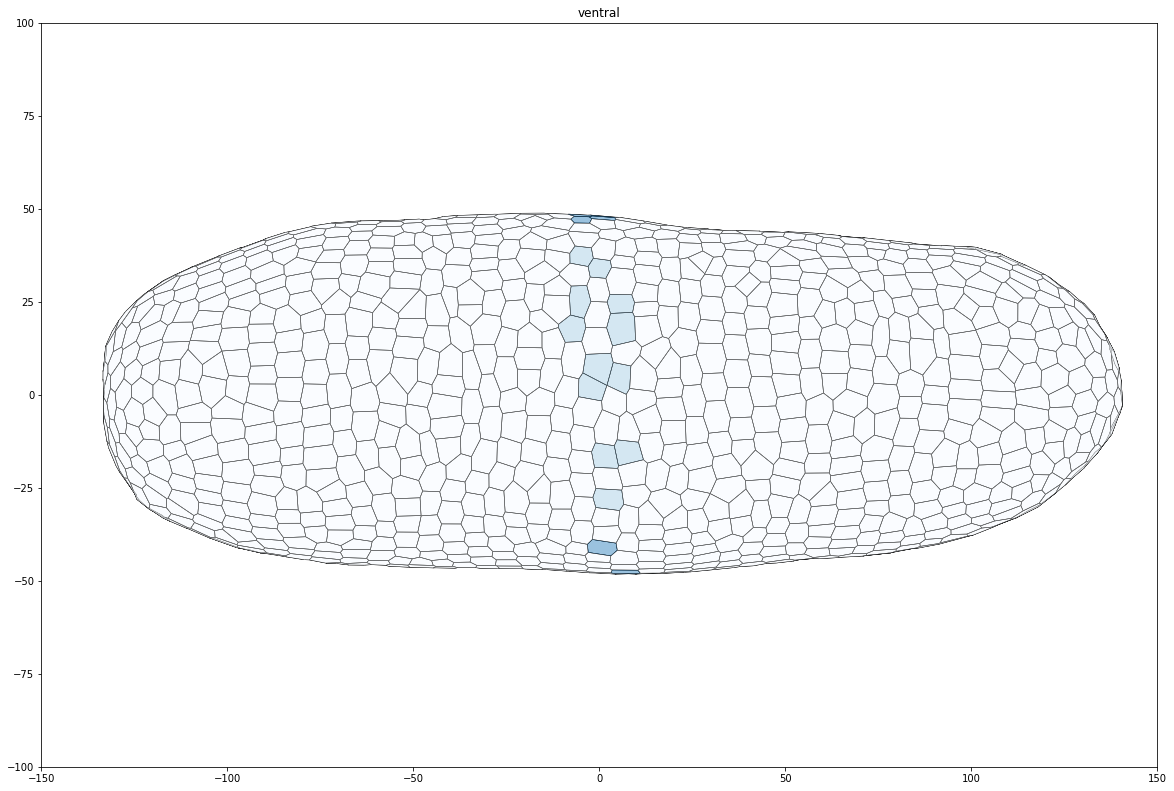

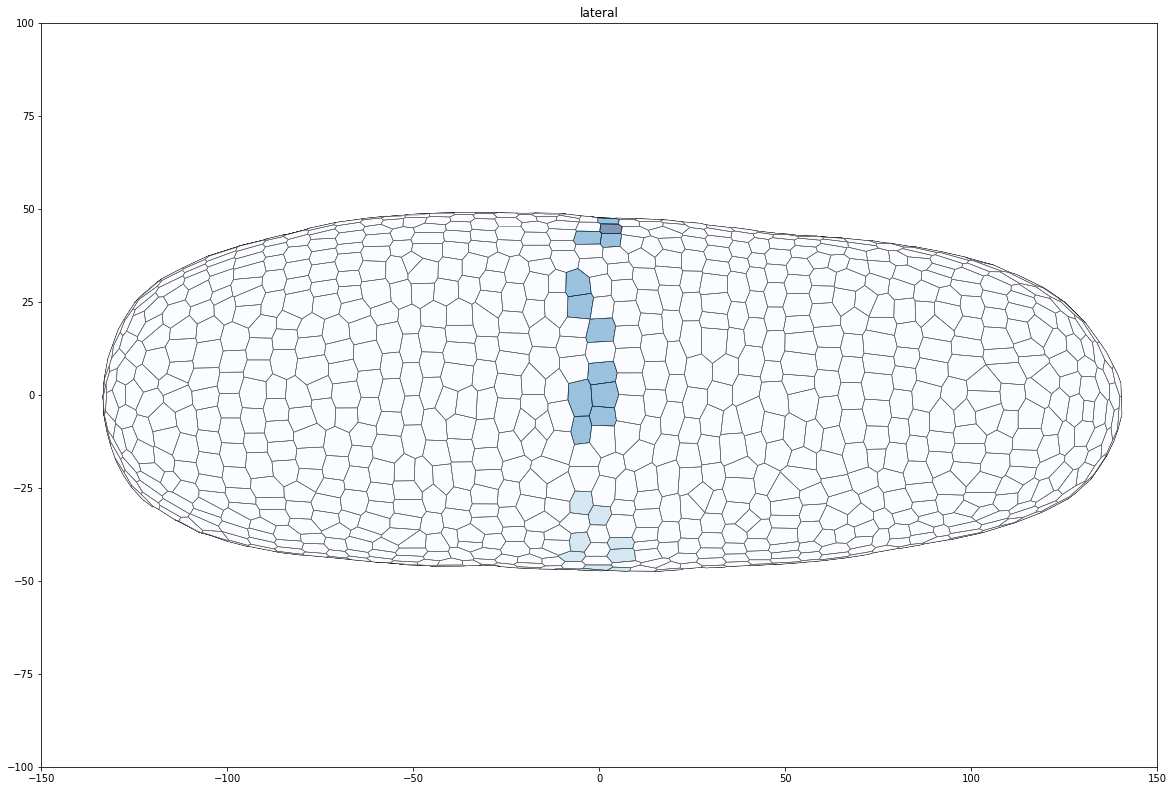

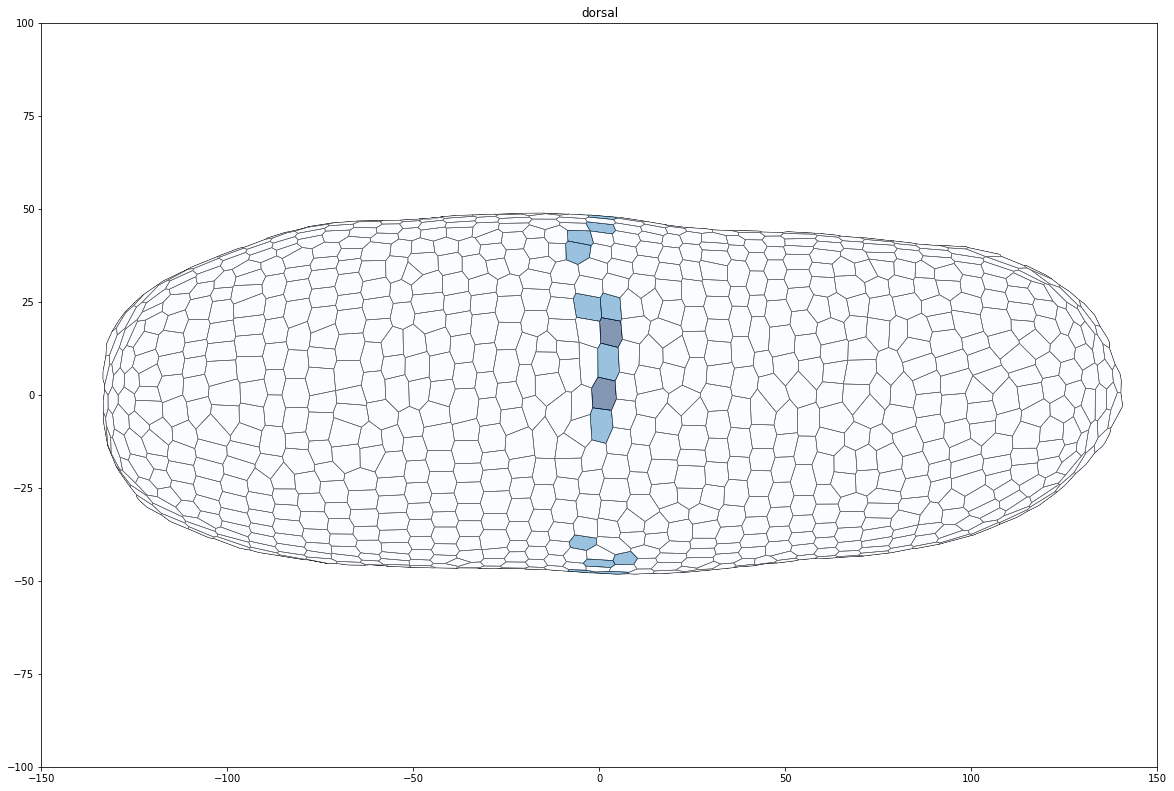

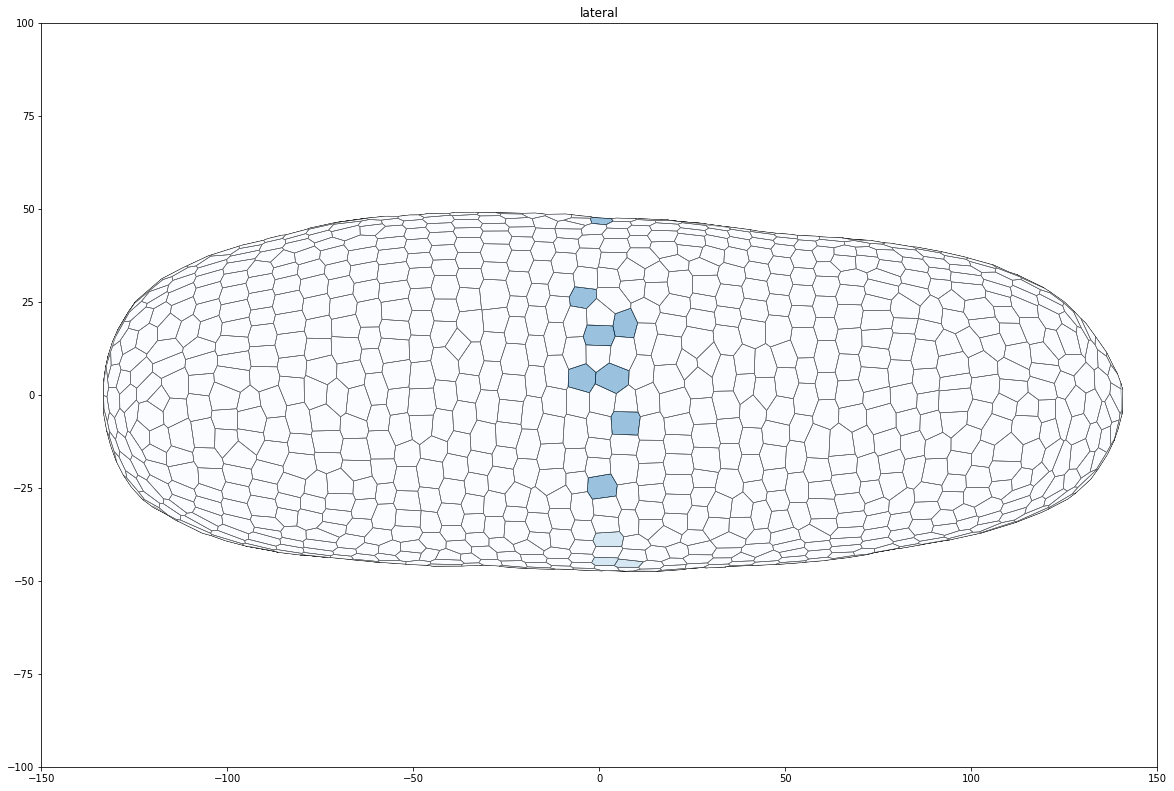

In [36]:
from tyssue.draw import sheet_view
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color':'k'
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.apoptosis,
            'colormap': 'Blues',
            'alpha':0.5,
            'color_range':(0,3)

        },
        
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs



sheet2=sheet.extract_bounding_box(x_boundary=(-150,0))
fig, ax = sheet_view(sheet2, ['z', 'y'], mode="2D", **draw_specs(sheet2))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)
ax.set_title("ventral")
fig.set_size_inches(20,20)
sheet2=sheet.extract_bounding_box(y_boundary=(0,150))
fig, ax = sheet_view(sheet2, ['z', 'x'], mode="2D", **draw_specs(sheet2))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)
ax.set_title("lateral")
fig.set_size_inches(20,20)
sheet2=sheet.extract_bounding_box(x_boundary=(0,150))
fig, ax = sheet_view(sheet2, ['z', 'y'], mode="2D", **draw_specs(sheet2))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)
ax.set_title("dorsal")
fig.set_size_inches(20,20)
sheet2=sheet.extract_bounding_box(y_boundary=(-150,0))
fig, ax = sheet_view(sheet2, ['z', 'x'], mode="2D", **draw_specs(sheet2))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)
ax.set_title("lateral")
fig.set_size_inches(20,20)

In [37]:
sheet.face_df[sheet.face_df.apoptosis>0].index

Int64Index([   3,    4,    7,   72,  175,  254,  440,  502,  540,  541,  696,
             698,  706,  767,  780,  818,  843,  892,  943, 1096, 1125, 1215,
            1294, 1330, 1339, 1388, 1424, 1491, 1544, 1566, 1569, 1603, 1615],
           dtype='int64', name='face')

In [13]:
sheet.face_df['current_traction'] = 0.0
sheet.face_df['radial_tension']=0.0

In [14]:
#Add clone cell
#clone of 4 cells

sheet.face_df['is_mesoderm']=0
"""index_clone_cells = sheet.face_df[(sheet.face_df.z>20) & (sheet.face_df.z<33) 
              & (sheet.face_df.y>41)&(sheet.face_df.y<51)
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index_clone_cells, 'is_mesoderm']=1

index_clone_cells = sheet.face_df[(sheet.face_df.z>20) & (sheet.face_df.z<30) 
              & (sheet.face_df.y>-51)&(sheet.face_df.y<-41)
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index_clone_cells, 'is_mesoderm']=1

index_clone_cells = sheet.face_df[(sheet.face_df.z>22) & (sheet.face_df.z<32) 
              & (sheet.face_df.y>-11)&(sheet.face_df.y<11)
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index_clone_cells, 'is_mesoderm']=1"""

index_clone_cells = sheet.face_df[(sheet.face_df.z>30) & (sheet.face_df.z<42) 
              & (sheet.face_df.y>28)&(sheet.face_df.y<39)
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index_clone_cells, 'is_mesoderm']=1

"""index_clone_cells = sheet.face_df[(sheet.face_df.z>20) & (sheet.face_df.z<30) 
              & (sheet.face_df.y>-25)&(sheet.face_df.y<-11)
                    & (sheet.face_df.x>0)].index
sheet.face_df.loc[index_clone_cells, 'is_mesoderm']=1"""


ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.fold+sheet.face_df.is_mesoderm,
                        'colormap':'Reds',
                        'visible':True})
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [15]:
def run_sim(sim_save_dir, sheet, constriction, radial_tension, iteration=0):
    
    dirname = '{}_constriction_{}_radialtension{}'.format(
        constriction,radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass

    
    apoptosis_settings = {
        "shrink_rate": 1.1,
        "critical_area": 0.5,
        "contract_rate": constriction,
        "basal_contract_rate": 1.01,
        "contract_span": 4,
        "radial_tension": radial_tension,
        "max_traction":30.,
        "current_traction":0.,
        "geom": geom,
    }
    
    delaminate_settings = {
        "shrink_rate": 1.1,
        'radial_tension': radial_tension*1.5,
        "contract_rate": constriction,
        "critical_area": 5,
        'current_traction': 0,
        'max_traction': 90,
        'contract_neighbors': False,
        'critical_area_neighbors': 12,
        'contract_span': 4,
        'basal_contract_rate': 1.01,
        'geom': geom,
        'contraction_column': 'contractility'}
    
    
    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    sheet2.settings['delamination'] = delaminate_settings
    
    #""" Initiale find minimal energy
    # To be sure we are at the equilibrium
    res = solver.find_energy_min(sheet2, geom, model, options={"gtol": 1e-8})


    sheet2 = apoptosis_process(dirname, solver, sheet2, geom, model)
    
    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [16]:
def apoptosis_process(dirname, solver, sheet, geom, model):
    
    # Initiate manager
    manager = EventManager('face')
    

    
    # Initiate history
    history = HistoryHdf5(sheet, 
                          extra_cols={"face": sheet.face_df.columns,
                                      "edge": list(sheet.edge_df.columns),
                                      "vert": list(sheet.vert_df.columns)},
                         hf5file=os.path.join(dirname, 'out.hf5'))
    
    #save settings
    pd.Series(sheet.settings).to_csv(os.path.join(dirname, 'settings.csv'))

    t = 0.
    stop = 150.
    
    # Add events to limit rosette 
    rosette_kwargs={
        'threshold_length':1e-6,
        'p_4':0.9,
        'p_5p':0.9}
    manager.append(reconnect, **rosette_kwargs)

        
    # Run simulation
    while t < stop:

        time_of_last_apoptosis = 30.   
            
        phi_min = -t*max(np.abs(sheet.face_df.phi))/30+max(np.abs(sheet.face_df.phi))

        l_index_apoptosis_cell = sheet.face_df[(np.abs(sheet.face_df.phi)>phi_min) 
                                               & (sheet.face_df.apoptosis>0)
                                              ].index.values
        apopto_kwargs = sheet.settings['apoptosis'].copy()
        for c in l_index_apoptosis_cell:
            apopto_kwargs.update(
            {
                'face_id': c,
            }
            )
            notpresent = True
            for tup in manager.next:
                if c in tup[1]:
                    notpresent = False
            if notpresent:
                print ('append \ŧ' + str(c))
                manager.append(apoptosis, **apopto_kwargs)

        if t == 5 : 
            for i in sheet.face_df[sheet.face_df.is_mesoderm==1].index:
                delamination_kwargs = sheet.settings['delamination'].copy()
                delamination_kwargs.update(
                        {
                            'face_id': i,
                            "max_traction":90,
                            "current_traction":0,
                        }
                    )
                manager.append(delamination, **delamination_kwargs)      
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0.
        
        
        manager.execute(sheet)
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
        #all_rearangements(sheet)
        #res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
    
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04.0f}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'        
        hdf5.save_datasets(hdfname, sheet)

        history.record()

        manager.update()
        t += 1

    return sheet


In [17]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()

radial_tension = [30., 40.]

contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]


contractility_rate, radial_tension = np.meshgrid(contractility_rate, radial_tension)

results = Parallel(n_jobs=2)(delayed(run_sim)(
    sim_save_dir, sheet, c, rd, 0) 
                             for c, rd in zip(contractility_rate.ravel(), radial_tension.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-09-09 14:58:50.401097


KeyboardInterrupt: 